In [1]:
# One run of test to deduplicate the bio_med_research dataset
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Initialize classifier
import xml.etree.ElementTree as ET
import json
from tqdm import tqdm

In [2]:
# if use colab, run this part
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/bionlp')

Mounted at /content/drive


In [3]:
os.chdir('MedImageInsights')

In [4]:
directory = "../dataset/QAs"

In [5]:
!pip install mup
!pip install fvcore

  Preparing metadata (setup.py) ... done
  Created wheel for mup: filename=mup-1.0.0-py3-none-any.whl size=23629 sha256=85d10b4375c17f732b73cdee478abe5449a6a95252a3271a95b234b7d04ea087
  Stored in directory: /root/.cache/pip/wheels/f4/c8/88/3c23a3d10c50053b6552d2d30aee5b53ba89a47f742420036c
Successfully built mup
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=8e0951448b31b83a26a5c5655ec89d7d2b7a1567034c86eec9dd7b6389342e03
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=5577ea7173ab7bc0e7507e38f08cdb7bd95e53cb24268941a1f8b4c7a6a7a59a
  Stored in directory:

In [6]:
# load model
from medimageinsightmodel import MedImageInsight

classifier = MedImageInsight(
    model_dir="2024.09.27",
    vision_model_name="medimageinsigt-v1.0.0.pt",
    language_model_name="language_model.pth"
)

# Load model
classifier.load_model()

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Model loaded successfully on device: cuda


In [7]:
# loading dataset
def parse_xml(file):
    tree = ET.parse(file)
    root = tree.getroot()

    sentence_data = []
    for sentence in root.findall('sentence'):
        sentence_id = sentence.get('id')
        sentence_text = sentence.get('text')

        sentence_data.append({
            "sentence_id": sentence_id,
            "sentence_text": sentence_text
        })

    return pd.DataFrame(sentence_data)


def load_dataset(path, filetype = "csv"):
    if filetype == "csv":
        all_files = []
        for root, dirs, files in tqdm(os.walk(path), desc = "Loading CSV files"):
            for file in tqdm(files, desc = "Processing file"):
                if file.endswith(".csv"):
                    all_files.append(os.path.join(root, file))
        ds = {}
        for f in all_files:
            df = pd.read_csv(f)
            ds[f] = df
        return ds
    elif filetype == "xml":
        all_files = []
        for root, dirs, files in tqdm(os.walk(path), desc = "Loading XML files"):
            for file in tqdm(files, desc = "Processing file"):
                if file.endswith(".xml"):
                    all_files.append(os.path.join(root, file))
        ds = {}
        for f in all_files:
            ds[f] = parse_xml(f)
        return ds
    elif filetype == "jsonl":
        all_files = []
        for root, dirs, files in tqdm(os.walk(path), desc = "Loading JSONL files"):
            for file in tqdm(files, desc = "Processing file"):
                if file.endswith(".jsonl"):
                    all_files.append(os.path.join(root, file))
        ds = {}
        for f in all_files:
            print("current file: ", f)
            with open(f, "r") as file:
                data = [json.loads(line) for line in file]
            ds[f] = pd.DataFrame(data)
        return ds
    elif filetype == "json":
        all_files = []
        for root, dirs, files in tqdm(os.walk(path), desc = "Loading JSON files"):
            for file in tqdm(files, desc = "Processing file"):
                if file.endswith(".json"):
                    all_files.append(os.path.join(root, file))
        ds = {}
        for f in all_files:
            with open(f, "r") as file:
                data = json.load(file)
            ds[f] = pd.DataFrame(data)
        return ds



In [8]:
# functions for deduplication
def get_embeddings(texts, batch_size = 64):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc = "Generating embeddings"):
        batch_texts = texts[i:i+batch_size]
        embeddings.extend(classifier.encode(texts = batch_texts)['text_embeddings'])
    return np.array(embeddings)

def compute_similarity(embeddings, threshold = 0.9):
    n = len(embeddings)
    to_remove = set()
    for i in tqdm(range(n), desc = "Computing similarity"):
        for j in range(i+1, n):
            sim = cosine_similarity(embeddings[i].reshape(1, -1), embeddings[j].reshape(1, -1))[0][0]
            if sim > threshold:
                to_remove.add(j)
    return to_remove

def compute_similarity_between_datasets(embeddings1, embeddings2, threshold = 0.9):
    to_remove = set()
    for i in tqdm(range(len(embeddings1)), desc = "Computing similarity"):
        for j in range(len(embeddings2)):
            sim = cosine_similarity(embeddings1[i].reshape(1, -1), embeddings2[j].reshape(1, -1))[0][0]
            if sim > threshold:
                to_remove.add(j)
    return to_remove

def deduplication_within_dataset_qa(dataset, threshold = 0.9):
    questions = dataset["question"].tolist()
    #answers = dataset["answer"].tolist()

    question_embeddings = get_embeddings(questions)
    to_remove_questions = compute_similarity(question_embeddings, threshold)

    new_dataset = dataset.drop(index = list(to_remove_questions)).reset_index(drop=True)

    answers = new_dataset["answer"].tolist()
    answer_embeddings = get_embeddings(answers)
    to_remove_answers = compute_similarity(answer_embeddings, threshold)

    new_dataset = new_dataset.drop(index = list(to_remove_answers)).reset_index(drop=True)
    return new_dataset, list(to_remove_questions), list(to_remove_answers)


def deduplicate_across_datasets_qa(old_datasets, new_dataset, threshold = 0.9):
    # Combine all old dataset questions and answers
    all_old_questions = []
    all_old_answers = []

    for dataset in old_datasets:
        all_old_questions.extend(dataset["question"].tolist())
        all_old_answers.extend(dataset["answer"].tolist())

    # Generate embeddings for old dataset questions and answers
    old_question_embeddings = get_embeddings(all_old_questions)
    old_answer_embeddings = get_embeddings(all_old_answers)

    # Generate embeddings for new dataset questions and answers
    new_question_embeddings = get_embeddings(new_dataset["question"].tolist())
    new_answer_embeddings = get_embeddings(new_dataset["answer"].tolist())

    # Deduplicate new questions
    to_remove_questions = compute_similarity_between_datasets(new_question_embeddings, old_question_embeddings)

    # Deduplicate new answers
    to_remove_answers = compute_similarity_between_datasets(new_answer_embeddings, old_answer_embeddings)

    # Combine removal indices
    to_remove = to_remove_questions.union(to_remove_answers)

    # Drop duplicates from new dataset
    deduplicated_new_dataset = new_dataset.drop(index=list(to_remove)).reset_index(drop=True)

    return deduplicated_new_dataset, list(to_remove_questions), list(to_remove_answers)



In [ ]:
ds_jsonl = load_dataset(directory, "jsonl")

current file:  ../dataset/QAs/MedQA-USMLE/questions/US/train.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/test.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/dev.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/US_qbank.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/metamap_extracted_phrases/test/phrases_test.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/metamap_extracted_phrases/train/phrases_train.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/metamap_extracted_phrases/dev/phrases_dev.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/4_options/phrases_no_exclude_test.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/4_options/phrases_no_exclude_dev.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/US/4_options/phrases_no_exclude_train.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/Taiwan/train.jsonl
current file:  ../dataset/QAs/MedQA-USMLE/questions/Taiwan/te

In [ ]:
ds_json = load_dataset(directory, "json")

In [ ]:
ds_csv = load_dataset(directory, "csv")

Processing file: 100%|██████████| 1/1 [00:00<00:00, 26886.56it/s]
Processing file: 0it [00:00, ?it/s]
Processing file: 100%|██████████| 4/4 [00:00<00:00, 152520.15it/s]
Processing file: 0it [00:00, ?it/s]
Processing file: 100%|██████████| 4/4 [00:00<00:00, 152520.15it/s]
Processing file: 0it [00:00, ?it/s]
Processing file: 100%|██████████| 1/1 [00:00<00:00, 47662.55it/s]
Processing file: 0it [00:00, ?it/s]
Processing file: 100%|██████████| 3/3 [00:00<00:00, 155344.59it/s]
Loading CSV files: 27it [00:00, 770.79it/s]


In [ ]:
ds_csv.keys()


dict_keys(['../dataset/QAs/MedicationQA/medicationqa_train_fulltext.csv'])

In [ ]:
medicationqa = ds_csv['../dataset/QAs/MedicationQA/medicationqa_train_fulltext.csv']

In [ ]:
#rename columns
medicationqa = medicationqa.rename(columns = {"Question": "question", "Answer": "answer"})

In [ ]:
#drop all na in question or answer
medicationqa.dropna(subset = ["question", "answer"], inplace = True)


In [ ]:
len(medicationqa)

689

In [ ]:
#deduplicate within dataset
medicationqa, removed_questions, removed_answers = deduplication_within_dataset_qa(medicationqa)
print(len(removed_questions), len(removed_answers))


Computing similarity: 100%|██████████| 630/630 [00:28<00:00, 22.40it/s] 

59 43


In [ ]:
medicationqa.to_csv("../deduplicated_data/QAs/MedicationQA/medicationqa_train_fulltext_deduplicated.csv", index = False)

In [9]:
ds_json = load_dataset(directory, "json")

Loading JSON files: 0it [00:00, ?it/s]
Processing file: 100%|██████████| 1/1 [00:00<00:00, 9383.23it/s]
Loading JSON files: 1it [00:00,  2.27it/s]
Processing file: 100%|██████████| 1/1 [00:00<00:00, 10459.61it/s]
Loading JSON files: 2it [00:00,  3.66it/s]
Processing file: 0it [00:00, ?it/s]
Loading JSON files: 3it [00:00,  4.33it/s]
Processing file: 100%|██████████| 2/2 [00:00<00:00, 20661.60it/s]
Loading JSON files: 4it [00:01,  3.88it/s]
Processing file: 100%|██████████| 18/18 [00:00<00:00, 212071.55it/s]

Processing file: 100%|██████████| 2/2 [00:00<00:00, 23172.95it/s]

Processing file: 100%|██████████| 1/1 [00:00<00:00, 10305.42it/s]

Processing file: 100%|██████████| 4/4 [00:00<00:00, 33354.31it/s]
Loading JSON files: 8it [00:01,  8.50it/s]
Processing file: 100%|██████████| 3/3 [00:00<00:00, 24818.37it/s]
Loading JSON files: 9it [00:01,  7.79it/s]
Processing file: 100%|██████████| 4/4 [00:00<00:00, 52924.97it/s]

Processing file: 100%|██████████| 3/3 [00:00<00:00, 35848.75it/s]
L

In [10]:
ds_json.keys()

dict_keys(['../dataset/QAs/PubMedQA/ori_pqal.json', '../dataset/QAs/PubMedQA/ori_pqau.json', '../dataset/QAs/PubMedQA/ori_pqaa.json'])

In [11]:
pubmedqa1 = ds_json['../dataset/QAs/PubMedQA/ori_pqaa.json'].T
pubmedqa2 = ds_json['../dataset/QAs/PubMedQA/ori_pqau.json'].T
pubmedqa3 = ds_json['../dataset/QAs/PubMedQA/ori_pqal.json'].T
print("Length of pubmedqa1: ", len(pubmedqa1))
print("Length of pubmedqa2: ", len(pubmedqa2))
print("Length of pubmedqa3: ", len(pubmedqa3))


Length of pubmedqa1:  211269
Length of pubmedqa2:  61249
Length of pubmedqa3:  1000


In [12]:
pubmedqa1.rename(columns = {"QUESTION": "question", "LONG_ANSWER": "answer"}, inplace = True)
pubmedqa2.rename(columns = {"QUESTION": "question", "LONG_ANSWER": "answer"}, inplace = True)
pubmedqa3.rename(columns = {"QUESTION": "question", "LONG_ANSWER": "answer"}, inplace = True)
pubmedqa1.dropna(subset = ["question", "answer"], inplace = True)
pubmedqa2.dropna(subset = ["question", "answer"], inplace = True)
pubmedqa3.dropna(subset = ["question", "answer"], inplace = True)

print("Length of pubmedqa1: ", len(pubmedqa1))
print("Length of pubmedqa2: ", len(pubmedqa2))
print("Length of pubmedqa3: ", len(pubmedqa3))



Length of pubmedqa1:  211269
Length of pubmedqa2:  61249
Length of pubmedqa3:  1000


In [15]:
# self deduplicate first
pubmedqa1, removed_questions, removed_answers = deduplication_within_dataset_qa(pubmedqa1)
print(len(removed_questions), len(removed_answers))

pubmedqa1.to_csv("../deduplicated_data/QAs/PubMedQA/ori_pqaa_deduplicated.csv", index = False)

Generating embeddings:   0%|          | 0/3302 [00:00<?, ?it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [13]:
pubmedqa3, removed_questions, removed_answers = deduplication_within_dataset_qa(pubmedqa3)
print(len(removed_questions), len(removed_answers))

pubmedqa3.to_csv("../deduplicated_data/QAs/PubMedQA/ori_pqal_deduplicated.csv", index = False)

Computing similarity: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]


0 0


In [14]:
pubmedqa2, removed_questions, removed_answers = deduplication_within_dataset_qa(pubmedqa2)
print(len(removed_questions), len(removed_answers))

pubmedqa2.to_csv("../deduplicated_data/QAs/PubMedQA/ori_pqau_deduplicated.csv", index = False)



Computing similarity:   0%|          | 1/61249 [00:56<968:38:54, 56.93s/it]


KeyboardInterrupt: 

In [15]:
pubmedqa3.to_csv("../deduplicated_data/QAs/PubMedQA/ori_pqal_deduplicated.csv", index = False)

In [16]:
# filter between sample
deduplicated_medicationqa = pd.read_csv("../deduplicated_data/QAs/MedicationQA/medicationqa_train_fulltext_deduplicated.csv")

In [18]:
# deduplicate across datasets
test_deduplicated_qa, removed_questions, removed_answers = deduplicate_across_datasets_qa([deduplicated_medicationqa], pubmedqa3)

Computing similarity: 100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


In [23]:
test_deduplicated_qa.head()

,question,CONTEXTS,LABELS,MESHES,YEAR,reasoning_required_pred,reasoning_free_pred,final_decision,answer
0,Do mitochondria play a role in remodelling lac...,[Programmed cell death (PCD) is the regulated ...,"[BACKGROUND, RESULTS]","[Alismataceae, Apoptosis, Cell Differentiation...",2011,yes,yes,yes,Results depicted mitochondrial dynamics in viv...
1,Landolt C and snellen e acuity: differences in...,[Assessment of visual acuity depends on the op...,"[BACKGROUND, PATIENTS AND METHODS, RESULTS]","[Adolescent, Adult, Aged, Aged, 80 and over, A...",2006,no,no,no,"Using the charts described, there was only a s..."
2,"Syncope during bathing in infants, a pediatric...",[Apparent life-threatening events in infants a...,"[BACKGROUND, CASE REPORTS]","[Baths, Histamine, Humans, Infant, Syncope, Ur...",1997,yes,yes,yes,"""Aquagenic maladies"" could be a pediatric form..."
3,Are the long-term results of the transanal pul...,[The transanal endorectal pull-through (TERPT)...,"[PURPOSE, METHODS, RESULTS]","[Child, Child, Preschool, Colectomy, Female, H...",2007,yes,no,no,Our long-term study showed significantly bette...
4,Can tailored interventions increase mammograph...,[Telephone counseling and tailored print commu...,"[BACKGROUND, DESIGN, PARTICIPANTS, INTERVENTIO...","[Cost-Benefit Analysis, Female, Health Mainten...",2000,yes,no,yes,The effects of the intervention were most pron...


In [24]:
threshold = 0.9
similarity_scores = []
all_questions = pd.concat([deduplicated_medicationqa["question"], pubmedqa3["question"]])
question_embeddings = get_embeddings(all_questions.tolist())
all_answers = pd.concat([deduplicated_medicationqa["answer"], pubmedqa3["answer"]])
answer_embeddings = get_embeddings(all_answers.tolist())

for i in range(len(question_embeddings)):
    for j in range(i+1, len(question_embeddings)):
        similarity_scores.append(cosine_similarity(question_embeddings[i].reshape(1, -1), question_embeddings[j].reshape(1, -1))[0][0])

for i in range(len(answer_embeddings)):
    for j in range(i+1, len(answer_embeddings)):
        similarity_scores.append(cosine_similarity(answer_embeddings[i].reshape(1, -1), answer_embeddings[j].reshape(1, -1))[0][0])

Generating embeddings: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


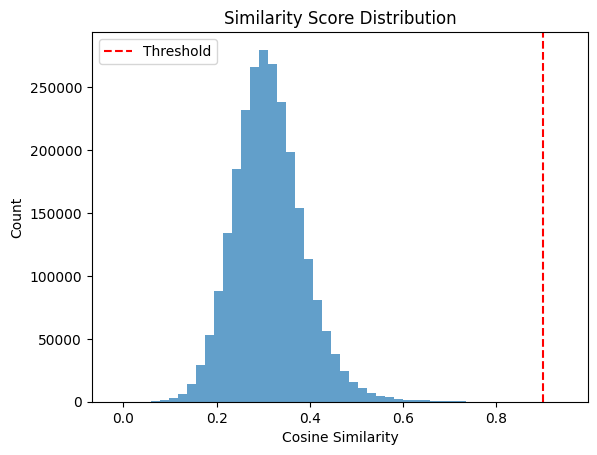

In [25]:
import matplotlib.pyplot as plt

plt.hist(similarity_scores, bins=50, alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Similarity Score Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.legend()
plt.show()

In [27]:
# store similarity scores
with open("similarity_scores.txt", "w") as f:
    for score in similarity_scores:
        f.write(str(score) + "\n")

In [ ]:
import seaborn as sns
import numpy as np

sns.heatmap(similarity_matrix, cmap="coolwarm", square=True)
plt.title("Heatmap of Pairwise Similarity Scores")
plt.show()
